# Gradient descent -- model file

In this file, we

1) Read potentential from an external file

2) Choose the values for the parameters: 
    - Optimizer: e.g. Adam
    - n_points: Number of randomly initialised points
    - n_steps: Maximum number of steps in gradient descent algorithm
    - spread: size of the hypercube with initial data
    - alpha: initial learning rate
    - n_steps_opt: frequency with which the optimizer is rebooted
    - step_stop_opt: step from which the rebooting is cancelled

3) Perform gradient descent

4) Create /Output/ directory if unavailable and store:
    - Cloud of points and loss function into a .npy files
    - Ancillary file stating the choices above and showing the evolution of the learning process

5) Define visualisation functions


=========================

Changes since Oct 31st:

1) Directory of input file with potential changed
2) Number of variables 'dim' not defined in the notebook, but read from the input file

Changes since Nov 6th:

3) Gradient descent updated with optimiser rebooted every few steps

## Gradient Descent

In [1]:
import os
from importlib.machinery import SourceFileLoader

import numpy as np 
import tensorflow as tf

In [2]:
##############################
# Parameters
##############################

potential = "pot_Higgs_4param"                          # .py file with potential function V(x) and the number of variables 'dim'

time = np.datetime_as_string(np.datetime64('now'))
time = time.replace('-','_').replace('T','_at_').replace(':','_')

n_points = 100000                                       # Number of randomly initialised points
n_steps = 2500                                          # Maximum number of steps in gradient descent algorithm
spread = 2.2                                            # Initial values for the cloud of points in the hypercube [-spread/2, spread/2]^dim


alpha=10**(-2)              # Initial learning rate
n_steps_opt = 200           # Number of steps before rebooting optimizer
step_stop_opt = 1500        


optimizer = tf.keras.optimizers.Adam(learning_rate=alpha)

optimizer_info = optimizer.get_config()





In [3]:
# Saving directory
out_dir = os.getcwd()+'/Output/'

try:
    os.mkdir(out_dir)
    print(f"Directory '{out_dir}' created successfully.")
except FileExistsError:
    print(f"Directory '{out_dir}' already exists.")
except PermissionError:
    print(f"Permission denied: Unable to create '{out_dir}'.")
except Exception as e:
    print(f"An error occurred: {e}")


# Output File names
attempt = f"_{potential}_{n_points}_{time}"

info_file = out_dir + 'Comments' + attempt + '.txt'
data_file = out_dir + 'Points' + attempt + '.npy'
loss_file = out_dir + 'Loss' + attempt + '.npy'


f_info = open(info_file, 'w')


f_info.write(f'File created on {time}')
f_info.write(f'\n\nPotential : {potential}')
f_info.write(f'\nNumber of points: {n_points}')
f_info.write(f'\nNumber of steps: {n_steps}\n')
f_info.write(f'\nn_steps_opt: {n_steps_opt}\n')
f_info.write(f'\nstep_stop_opt: {step_stop_opt}\n')
f_info.write('\nOptimizer:\n')


for key, value in optimizer_info.items(): 
    f_info.write('  - %s : %s\n' % (key, value))

f_info.write('\nEvolution:')
f_info.flush()

Directory '/Users/gabriel.larios/Desktop/Fisica/7 PostDoc TAMU/0A Projects/[On] CM_scan/Code/Output/' already exists.


In [4]:
# Loading the potential
module = SourceFileLoader(potential,os.getcwd()+'/Potential_generator/'+potential+'.py').load_module()
V = module.V
dim = module.dim

print(dim)
help(V)

4
Help on function V in module pot_Higgs_4param:

V(x)
    V = (-1 + x1 ** 2 + x2 ** 2) ** 2 + x3 ** 2 + x4 ** 2



In [5]:
# compute (||∇V||^2)
def grad_norm_squared(V, x):
    
    # Record operations for automatic differentiation:
    with tf.GradientTape() as tape:
        tape.watch(x)
        loss = V(x)                                     # compute V at each point
    gradients = tape.gradient(loss, x)                  # compute ∇V at each point
    norm_squared = tf.reduce_sum(gradients**2, axis=1)  # ||∇V||^2 at each point
    return norm_squared

In [6]:
# Randomly initialize the points
x = tf.Variable(spread*np.random.rand(n_points, dim)-(spread/2), dtype=tf.float32)


loss_history = []

update_opt = True


# Learning loop 
for step in range(n_steps):  
    with tf.GradientTape() as tape:
        loss = tf.reduce_sum(grad_norm_squared(V, x))  # minimize ||∇V||^2 for all points
        loss_history.append(loss)
    
    # Compute ||∇V||^2 with respect to x
    gradients = tape.gradient(loss, [x])
        
    # Apply gradient descent for all points
    optimizer.apply_gradients(zip(gradients, [x]))
    
    # Updates of optimizer
    if update_opt and step % n_steps_opt ==0 :
        print("Reinitializing the optimizer")
        optimizer = tf.optimizers.Adam(learning_rate=alpha)

    if step == step_stop_opt:
        update_opt = False
    
    if (step - step_stop_opt)%(3*n_steps_opt) == 0:
        alpha = alpha/10
        optimizer = tf.optimizers.Adam(learning_rate=alpha)


    # Update the information in info file
    if step % 10 == 0:
        f_info.write(f"\n  Step {step}: ||∇V||^2 = {loss.numpy()}")
        f_info.flush()
        
    if np.log(loss.numpy())/np.log(10)<-8: 
        f_info.write("\n\nConverged enough") 
        f_info.write(f"\n  Step {step}: ||∇V||^2 = {loss.numpy()}")
        break

f_info.close()

# Saving loss and final cloud of points
np.save(data_file,x)
np.save(loss_file,loss_history)

Reinitializing the optimizer


Reinitializing the optimizer


Reinitializing the optimizer


Reinitializing the optimizer


Reinitializing the optimizer


Reinitializing the optimizer


## Results

In [1]:
import os
from importlib.machinery import SourceFileLoader

import numpy as np 
import matplotlib.pyplot as plt

from matplotlib.colors import LogNorm

import tensorflow as tf

### Functions

In [2]:
# compute (||∇V||^2)
def grad_norm_squared(V, x):
    
    # Record operations for automatic differentiation:
    with tf.GradientTape() as tape:
        tape.watch(x)
        loss = V(x)                                     # compute V at each point
    gradients = tape.gradient(loss, x)                  # compute ∇V at each point
    norm_squared = tf.reduce_sum(gradients**2, axis=1)  # ||∇V||^2 at each point
    return norm_squared

In [3]:
def triangular_plot(chains,figname):
    data=chains
    nsteps,ndim=chains.shape
    fig = plt.figure(figsize=(20,20))
    for i in range(ndim):
        ax = fig.add_subplot(ndim,ndim,i*ndim+i+1)
        
        ax.hist(data[:,i], 100, color="k", histtype="step")
        ax.set_title(f"x{i+1} counts")

    for i in range(ndim):
        for j in range(i):
            ax = fig.add_subplot(ndim,ndim,i*ndim+j+1)
            counts,xbins,ybins,image = ax.hist2d(data[:,j],data[:,i],bins=100, norm=LogNorm(), cmap = plt.cm.rainbow)
            plt.colorbar(image)
            ax.contour(counts.transpose(),extent=[xbins[0],xbins[-1],ybins[0],ybins[-1]], linewidths=0.5, cmap = plt.cm.rainbow, levels = [1,100,1000,10000])
            ax.set_xlabel(f'x{j+1}')
            ax.set_ylabel(f'x{i+1}')
    plt.savefig(figname)
    plt.show()


def triangular_plot_slopes(chains):
    data=chains.numpy()
    nsteps,ndim=chains.shape
    fig = plt.figure(figsize=(15,15))
    for i in range(ndim):
        for j in range(i):
            ax=fig.add_subplot(ndim,ndim,ndim*i+j+1)
            those_slope0=np.extract(np.abs(data[:,0])>0.2,data[:,i]/data[:,j])
            those_slope=np.extract(np.abs(those_slope0)<10,those_slope0)
            ax.hist(those_slope,bins=100)
            ax.set_title(f"x{j}/x{i}")
    plt.show()

### Analysis

In [4]:
# Loading the potential
potential = "pot_Higgs_4param"                         # .py file with potential function V(x)
module = SourceFileLoader(potential,os.getcwd()+'/Potential_generator/'+potential+'.py').load_module()
V = module.V
dim = module.dim


out_dir = os.getcwd()+'/Output/'
time = '2024_11_21_at_20_21_15'
n_points = 100000

attempt = f"_{potential}_{n_points}_{time}"

data_file = out_dir + 'Points' + attempt + '.npy'
loss_file = out_dir + 'Loss' + attempt + '.npy'

In [5]:

x = tf.Variable(np.load(data_file), dtype=tf.float32)
loss_history = np.load(loss_file)

In [6]:
for i in range(15):
    print(f"Number of points with ||∇V||^2 > {10**(-i)} : {sum(grad_norm_squared(V,x).numpy()>10**(-i))}")

Number of points with ||∇V||^2 > 1 : 0
Number of points with ||∇V||^2 > 0.1 : 0
Number of points with ||∇V||^2 > 0.01 : 0
Number of points with ||∇V||^2 > 0.001 : 0
Number of points with ||∇V||^2 > 0.0001 : 0
Number of points with ||∇V||^2 > 1e-05 : 0
Number of points with ||∇V||^2 > 1e-06 : 0
Number of points with ||∇V||^2 > 1e-07 : 0
Number of points with ||∇V||^2 > 1e-08 : 0
Number of points with ||∇V||^2 > 1e-09 : 0
Number of points with ||∇V||^2 > 1e-10 : 0
Number of points with ||∇V||^2 > 1e-11 : 0
Number of points with ||∇V||^2 > 1e-12 : 1182
Number of points with ||∇V||^2 > 1e-13 : 21281
Number of points with ||∇V||^2 > 1e-14 : 38778


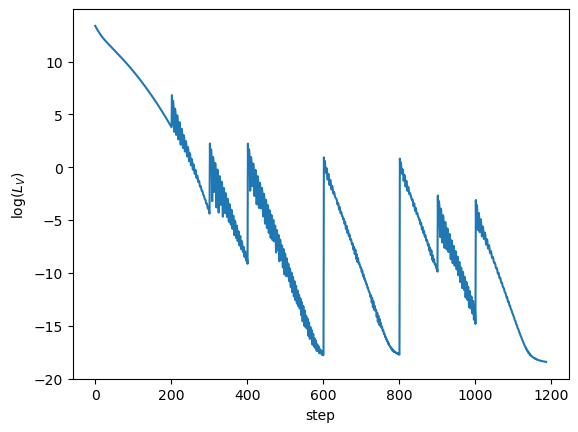

In [7]:
plt.figure(1)
plt.plot(np.log(loss_history))
plt.xlabel('step')
plt.ylabel('$\log(L_{V})$')
plt.show()

<Figure size 640x480 with 0 Axes>

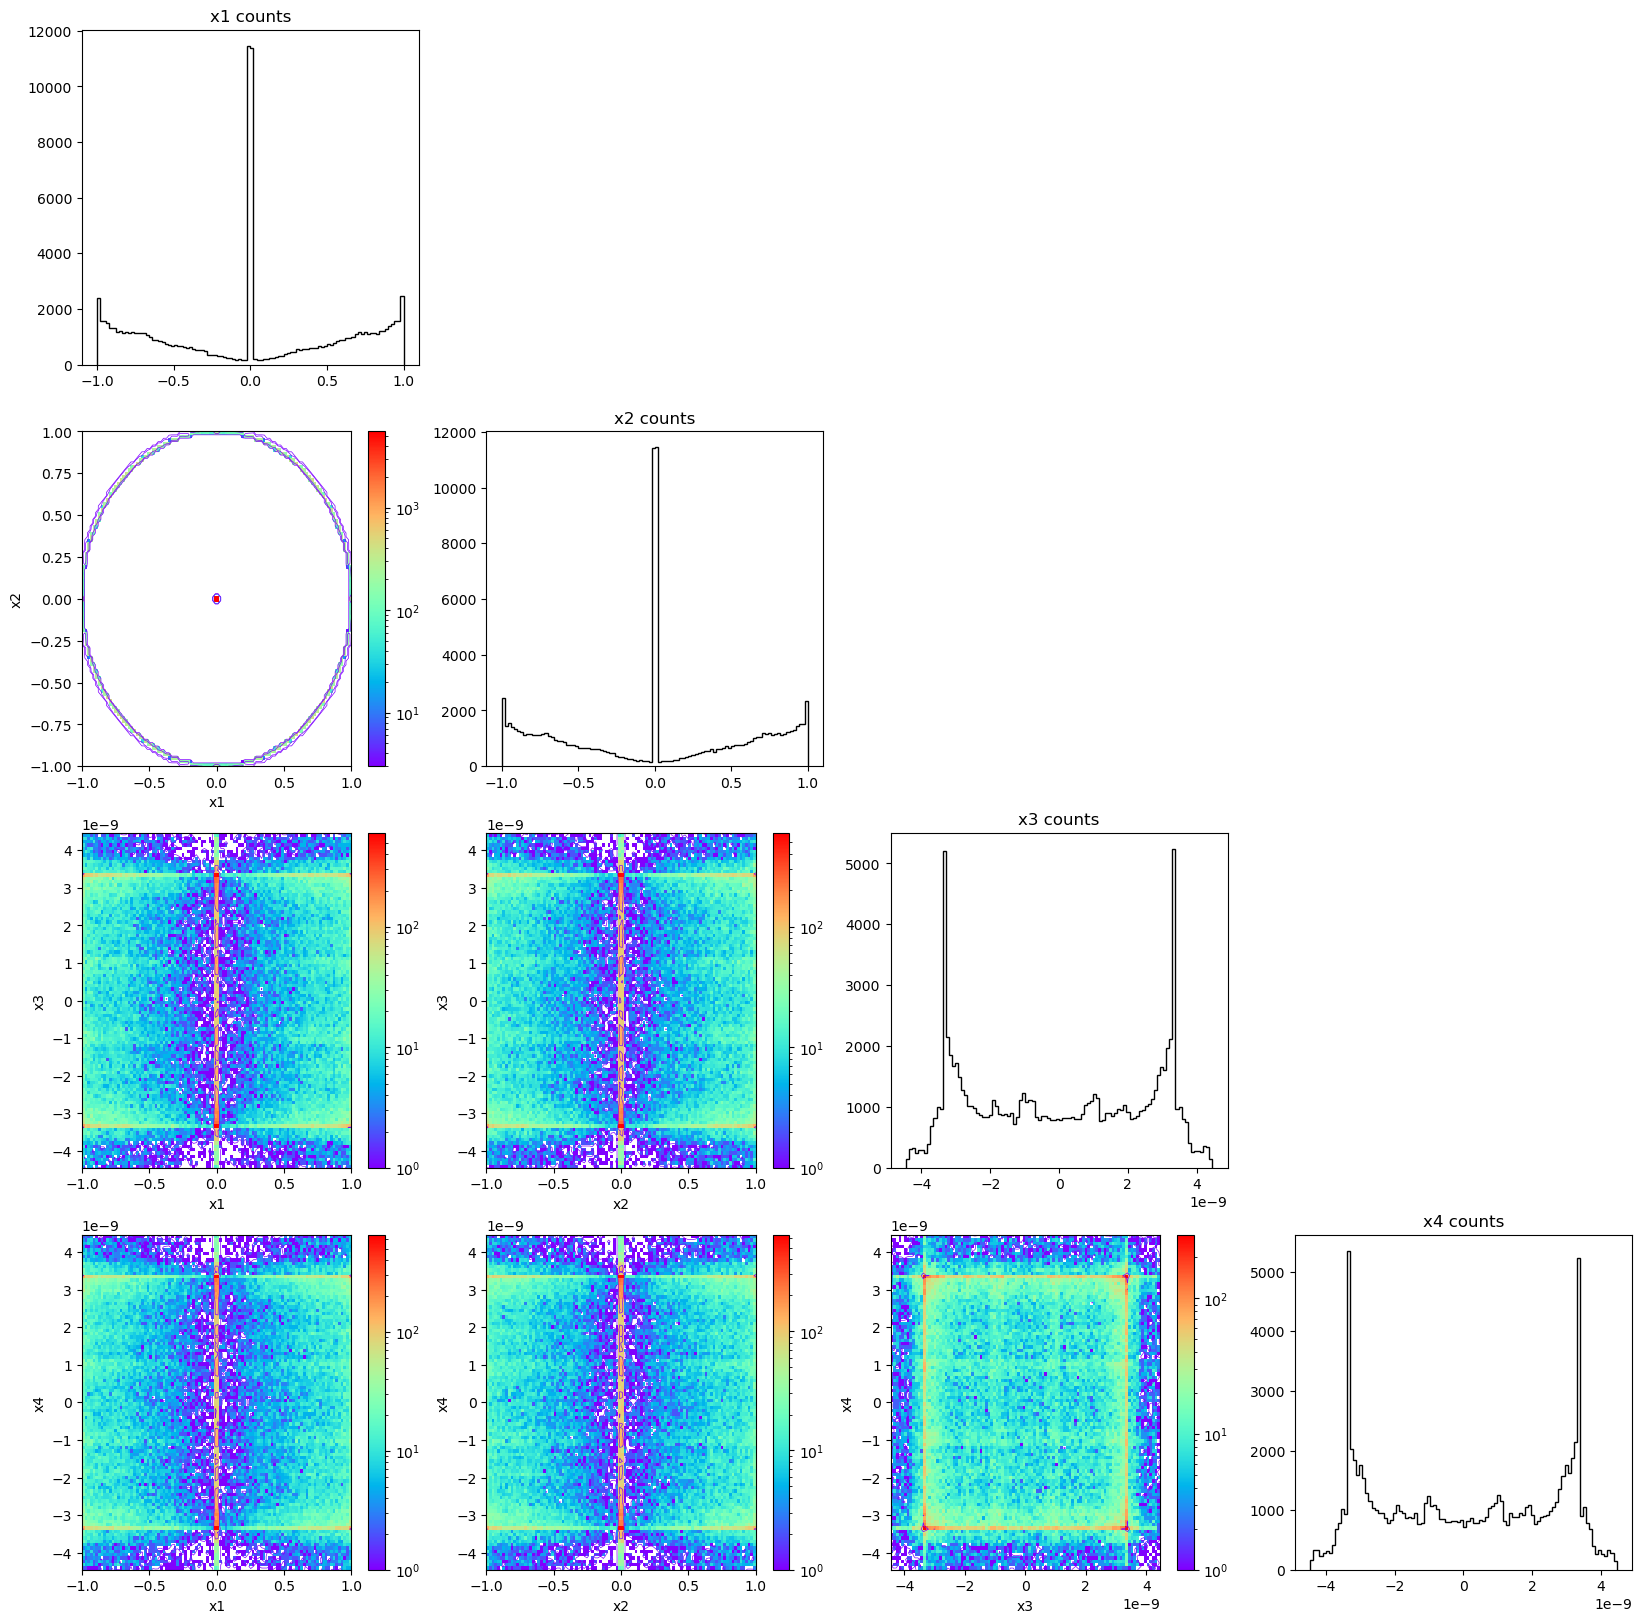

In [8]:
plt.figure(1)
triangular_plot(x.numpy(),'../LaTex/Notes/Figures/triangle_higgs.png')


## Autoencoder

In [9]:
import os
from importlib.machinery import SourceFileLoader


import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import tensorflow as tf

from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
from tensorflow.keras.models import Model

In [10]:
# Loading the potential
potential = "pot_Higgs_4param"                         # .py file with potential function V(x)
module = SourceFileLoader(potential,os.getcwd()+'/Potential_generator/'+potential+'.py').load_module()
V = module.V
dim = module.dim


out_dir = os.getcwd()+'/Output/'
time = '2024_11_21_at_20_21_15'
n_points = 100000

attempt = f"_{potential}_{n_points}_{time}"

data_file = out_dir + 'Points' + attempt + '.npy'
loss_file = out_dir + 'Loss' + attempt + '.npy'

In [11]:
x = np.load(data_file)
loss_history = np.load(loss_file)

In [12]:
x_train, x_test = train_test_split(x, test_size=0.15, random_state=42)

In [13]:
print(f'shape of total set of points: {x.shape}')
print(f'shape of training set of points: {x_train.shape}')
print(f'shape of validation set of points: {x_test.shape}')

shape of total set of points: (100000, 4)
shape of training set of points: (85000, 4)
shape of validation set of points: (15000, 4)


### Latent dimension = 1

In [14]:
input_dim = 4  
latent_dim = 1  

# Encoder
inputs = layers.Input(shape=(input_dim,))
encoded = layers.Dense(32, activation='sigmoid')(inputs)
encoded = layers.Dense(16, activation='sigmoid')(encoded)
encoded = layers.Dense(8, activation='sigmoid')(encoded)
encoded = layers.Dense(latent_dim)(encoded)  

# Decoder
decoded = layers.Dense(8, activation='sigmoid')(encoded)
decoded = layers.Dense(16, activation='sigmoid')(decoded)
decoded = layers.Dense(32, activation='sigmoid')(decoded)
decoded = layers.Dense(input_dim)(decoded)  

# Autoencoder 
autoencoder = models.Model(inputs, decoded)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
autoencoder.compile(optimizer=optimizer, loss='mse')

In [15]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 4)]               0         
                                                                 
 dense (Dense)               (None, 32)                160       
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 8)                 136       
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
 dense_4 (Dense)             (None, 8)                 16        
                                                                 
 dense_5 (Dense)             (None, 16)                144   

In [16]:
epochs = 500
history_AE_1 = autoencoder.fit(x_train, x_train, epochs=epochs, batch_size=100, shuffle=True,validation_data=(x_test, x_test))

Epoch 1/500


2024-11-27 14:15:11.229694: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


850/850 [==============================] - 1s 623us/step - loss: 0.2745 - val_loss: 0.1958
Epoch 2/500
850/850 [==============================] - 0s 546us/step - loss: 0.1949 - val_loss: 0.1954
Epoch 3/500
850/850 [==============================] - 0s 559us/step - loss: 0.1937 - val_loss: 0.1922
Epoch 4/500
850/850 [==============================] - 0s 545us/step - loss: 0.1781 - val_loss: 0.1530
Epoch 5/500
850/850 [==============================] - 0s 542us/step - loss: 0.1252 - val_loss: 0.1074
Epoch 6/500
850/850 [==============================] - 0s 538us/step - loss: 0.1042 - val_loss: 0.1012
Epoch 7/500
850/850 [==============================] - 0s 550us/step - loss: 0.1010 - val_loss: 0.0992
Epoch 8/500
850/850 [==============================] - 0s 537us/step - loss: 0.0994 - val_loss: 0.0981
Epoch 9/500
850/850 [==============================] - 0s 560us/step - loss: 0.0986 - val_loss: 0.0975
Epoch 10/500
850/850 [==============================] - 0s 542us/step - loss: 0.0982 

In [17]:
autoencoder_1 = autoencoder
encoder_1 = models.Model(inputs,encoded)
decoder_1 = models.Model(encoded,decoded)

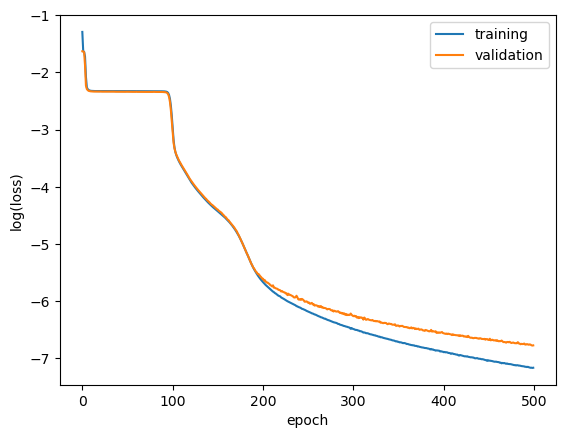

In [18]:
plt.plot(np.log(history_AE_1.history['loss']), label='training')
plt.plot(np.log(history_AE_1.history['val_loss']), label='validation')
plt.xlabel('epoch')
plt.ylabel('log(loss)')
plt.legend()

469/469 [==============================] - 0s 242us/step


(array([ 229.,  121.,  615., 4795., 7252., 1517.,  177.,   59.,   51.,
         184.]),
 array([-6.98371315, -5.26574183, -3.5477705 , -1.82979918, -0.11182785,
         1.60614347,  3.3241148 ,  5.04208612,  6.76005745,  8.47802925,
        10.1960001 ]),
 <BarContainer object of 10 artists>)

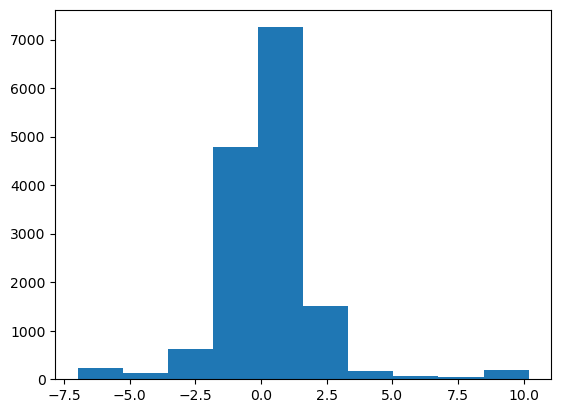

In [19]:
# test autoencoder
encoded_points = encoder_1.predict(x_test)

plt.hist(encoded_points)

### Latent dimension = 2

In [20]:
input_dim = 4  
latent_dim = 2

# Encoder
inputs = layers.Input(shape=(input_dim,))
encoded = layers.Dense(32, activation='sigmoid')(inputs)
encoded = layers.Dense(16, activation='sigmoid')(encoded)
encoded = layers.Dense(8, activation='sigmoid')(encoded)
encoded = layers.Dense(latent_dim)(encoded)  

# Decoder
decoded = layers.Dense(8, activation='sigmoid')(encoded)
decoded = layers.Dense(16, activation='sigmoid')(decoded)
decoded = layers.Dense(32, activation='sigmoid')(decoded)
decoded = layers.Dense(input_dim)(decoded)  

# Autoencoder 
autoencoder = models.Model(inputs, decoded)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
autoencoder.compile(optimizer=optimizer, loss='mse')

In [21]:
autoencoder.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 4)]               0         
                                                                 
 dense_8 (Dense)             (None, 32)                160       
                                                                 
 dense_9 (Dense)             (None, 16)                528       
                                                                 
 dense_10 (Dense)            (None, 8)                 136       
                                                                 
 dense_11 (Dense)            (None, 2)                 18        
                                                                 
 dense_12 (Dense)            (None, 8)                 24        
                                                                 
 dense_13 (Dense)            (None, 16)                144 

In [22]:
epochs = 500
history_AE_2 = autoencoder.fit(x_train, x_train, epochs=epochs, batch_size=100, shuffle=True,validation_data=(x_test, x_test))

Epoch 1/500
850/850 [==============================] - 1s 643us/step - loss: 0.2072 - val_loss: 0.1960
Epoch 2/500
850/850 [==============================] - 0s 572us/step - loss: 0.1951 - val_loss: 0.1960
Epoch 3/500
850/850 [==============================] - 0s 558us/step - loss: 0.1947 - val_loss: 0.1944
Epoch 4/500
850/850 [==============================] - 0s 572us/step - loss: 0.1831 - val_loss: 0.1601
Epoch 5/500
850/850 [==============================] - 0s 582us/step - loss: 0.1264 - val_loss: 0.1093
Epoch 6/500
850/850 [==============================] - 0s 575us/step - loss: 0.1045 - val_loss: 0.1041
Epoch 7/500
850/850 [==============================] - 0s 571us/step - loss: 0.1007 - val_loss: 0.1011
Epoch 8/500
850/850 [==============================] - 0s 579us/step - loss: 0.0987 - val_loss: 0.1000
Epoch 9/500
850/850 [==============================] - 0s 574us/step - loss: 0.0981 - val_loss: 0.0996
Epoch 10/500
850/850 [==============================] - 0s 584us/step - l

In [23]:
autoencoder_2 = autoencoder
encoder_2 = models.Model(inputs,encoded)
decoder_2 = models.Model(encoded,decoded)

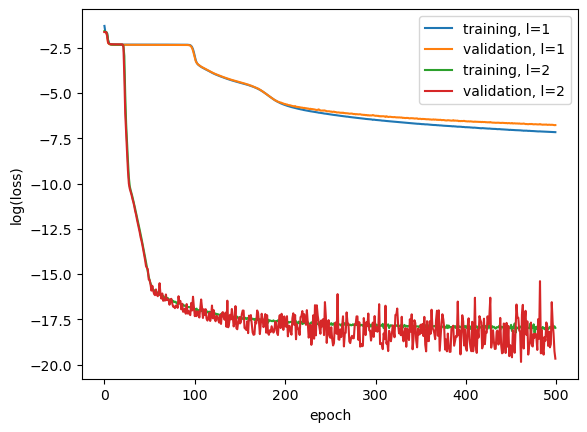

In [24]:
plt.plot(np.log(history_AE_1.history['loss']), label='training, l=1')
plt.plot(np.log(history_AE_1.history['val_loss']), label='validation, l=1')
plt.plot(np.log(history_AE_2.history['loss']), label='training, l=2')
plt.plot(np.log(history_AE_2.history['val_loss']), label='validation, l=2')
plt.xlabel('epoch')
plt.ylabel('log(loss)')
plt.legend()

In [25]:
# test autoencoder
encoded_points = encoder_2.predict(x_test)

469/469 [==============================] - 0s 259us/step


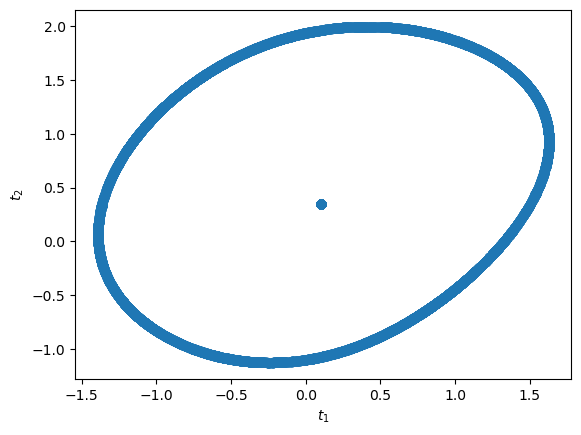

In [26]:
plt.scatter(encoded_points[:,0],encoded_points[:,1])
plt.xlabel('$t_1$')
plt.ylabel('$t_2$')
plt.savefig('../LaTeX/Notes/Figures/encoded_Higgs_l2.png')

### Latent dimension = 3

In [27]:
input_dim = 4  
latent_dim = 3

# Encoder
inputs = layers.Input(shape=(input_dim,))
encoded = layers.Dense(32, activation='sigmoid')(inputs)
encoded = layers.Dense(16, activation='sigmoid')(encoded)
encoded = layers.Dense(8, activation='sigmoid')(encoded)
encoded = layers.Dense(latent_dim)(encoded)  

# Decoder
decoded = layers.Dense(8, activation='sigmoid')(encoded)
decoded = layers.Dense(16, activation='sigmoid')(decoded)
decoded = layers.Dense(32, activation='sigmoid')(decoded)
decoded = layers.Dense(input_dim)(decoded)  

# Autoencoder 
autoencoder = models.Model(inputs, decoded)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
autoencoder.compile(optimizer=optimizer, loss='mse')

In [28]:
autoencoder.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 4)]               0         
                                                                 
 dense_16 (Dense)            (None, 32)                160       
                                                                 
 dense_17 (Dense)            (None, 16)                528       
                                                                 
 dense_18 (Dense)            (None, 8)                 136       
                                                                 
 dense_19 (Dense)            (None, 3)                 27        
                                                                 
 dense_20 (Dense)            (None, 8)                 32        
                                                                 
 dense_21 (Dense)            (None, 16)                144 

In [29]:
epochs = 500
history_AE_3 = autoencoder.fit(x_train, x_train, epochs=epochs, batch_size=100, shuffle=True,validation_data=(x_test, x_test))

Epoch 1/500
850/850 [==============================] - 1s 636us/step - loss: 0.2256 - val_loss: 0.1960
Epoch 2/500
850/850 [==============================] - 0s 550us/step - loss: 0.1951 - val_loss: 0.1958
Epoch 3/500
850/850 [==============================] - 0s 546us/step - loss: 0.1946 - val_loss: 0.1945
Epoch 4/500
850/850 [==============================] - 0s 548us/step - loss: 0.1870 - val_loss: 0.1735
Epoch 5/500
850/850 [==============================] - 0s 545us/step - loss: 0.1429 - val_loss: 0.1180
Epoch 6/500
850/850 [==============================] - 0s 559us/step - loss: 0.1085 - val_loss: 0.1059
Epoch 7/500
850/850 [==============================] - 0s 555us/step - loss: 0.1015 - val_loss: 0.1015
Epoch 8/500
850/850 [==============================] - 0s 553us/step - loss: 0.0987 - val_loss: 0.1000
Epoch 9/500
850/850 [==============================] - 0s 548us/step - loss: 0.0979 - val_loss: 0.0997
Epoch 10/500
850/850 [==============================] - 0s 550us/step - l

In [30]:
autoencoder_3 = autoencoder
encoder_3 = models.Model(inputs,encoded)
decoder_3 = models.Model(encoded,decoded)

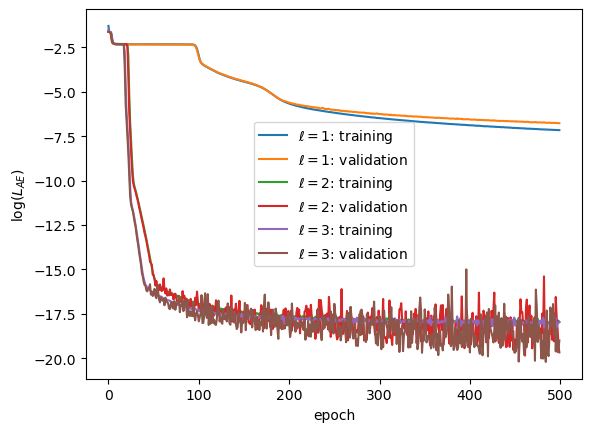

In [31]:
plt.plot(np.log(history_AE_1.history['loss']), label='$\ell=1$: training')
plt.plot(np.log(history_AE_1.history['val_loss']), label='$\ell=1$: validation')
plt.plot(np.log(history_AE_2.history['loss']), label='$\ell=2$: training')
plt.plot(np.log(history_AE_2.history['val_loss']), label='$\ell=2$: validation')
plt.plot(np.log(history_AE_3.history['loss']), label='$\ell=3$: training')
plt.plot(np.log(history_AE_3.history['val_loss']), label='$\ell=3$: validation')
plt.xlabel('epoch')
plt.ylabel('$\log(L_{AE})$')
plt.legend()
plt.savefig('../LaTeX/Notes/Figures/lossAE_higgs.png')

In [32]:
# test autoencoder
encoded_points = encoder_3.predict(x_test)

469/469 [==============================] - 0s 263us/step


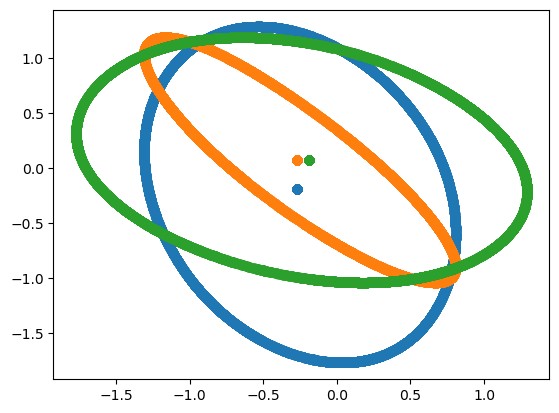

In [33]:
plt.scatter(encoded_points[:,0],encoded_points[:,1])
plt.scatter(encoded_points[:,0],encoded_points[:,2])
plt.scatter(encoded_points[:,1],encoded_points[:,2])

### Filtering and AE again

In [34]:
encoded_points = encoder_2.predict(x)

3125/3125 [==============================] - 1s 244us/step


In [35]:
encoded_points[:10]

array([[-0.47625953,  1.706772  ],
       [ 0.09931856,  0.3429327 ],
       [-1.2234576 , -0.5638795 ],
       [ 0.29123428, -1.0014274 ],
       [ 1.5985248 ,  0.6529094 ],
       [ 0.09931856,  0.3429327 ],
       [ 0.09931856,  0.34293264],
       [ 0.09931856,  0.3429327 ],
       [ 0.80964947,  1.9397985 ],
       [-0.98347235, -0.84679663]], dtype=float32)

In [41]:
centr_appr = [0.09931856,  0.3429327]
func = lambda x: np.sqrt((x[0]-centr_appr[0])**2+(x[1]-centr_appr[1])**2)>.5
mask = [func(i) for i in encoded_points]

In [ ]:
# The mask rejects points at the origin
x[~np.array(mask)]

array([[-4.1248862e-09,  4.0271395e-09,  1.0649730e-09,  2.9760359e-09],
       [-5.0519109e-09, -3.7415799e-09, -1.8772752e-09, -2.7948077e-09],
       [-3.3680299e-09, -3.9759112e-09,  1.2307968e-09, -1.5676695e-09],
       ...,
       [-4.1882307e-09,  4.6109681e-09, -3.3506649e-09, -2.9850646e-09],
       [-5.0471738e-09,  4.8369442e-09,  1.5989667e-09,  1.0231302e-09],
       [-5.8064042e-10,  5.0050071e-09,  3.9062997e-09, -2.1670306e-09]],
      dtype=float32)

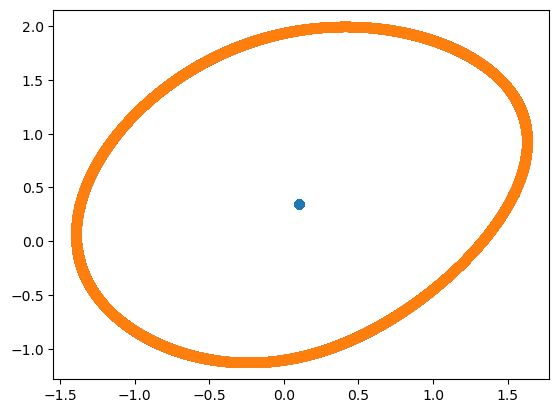

In [59]:
plt.scatter(encoded_points[:,0],encoded_points[:,1])
plt.scatter(encoded_points[mask,0],encoded_points[mask,1])

In [58]:
x_filtered = x[mask]
x_filt_train, x_filt_test = train_test_split(x_filtered, test_size=0.15, random_state=42)
print(f'shape of total set of points: {x_filtered.shape}')
print(f'shape of training set of points: {x_filt_train.shape}')
print(f'shape of validation set of points: {x_filt_test.shape}')

shape of total set of points: (78107, 4)
shape of training set of points: (66390, 4)
shape of validation set of points: (11717, 4)


In [60]:
input_dim = 4  
latent_dim = 1

# Encoder
inputs = layers.Input(shape=(input_dim,))
encoded = layers.Dense(32, activation='sigmoid')(inputs)
encoded = layers.Dense(16, activation='sigmoid')(encoded)
encoded = layers.Dense(8, activation='sigmoid')(encoded)
encoded = layers.Dense(latent_dim)(encoded)  

# Decoder
decoded = layers.Dense(8, activation='sigmoid')(encoded)
decoded = layers.Dense(16, activation='sigmoid')(decoded)
decoded = layers.Dense(32, activation='sigmoid')(decoded)
decoded = layers.Dense(input_dim)(decoded)  

# Autoencoder 
autoencoder = models.Model(inputs, decoded)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
autoencoder.compile(optimizer=optimizer, loss='mse')

In [61]:
epochs = 250
history_AE_filt_1 = autoencoder.fit(x_filt_train, x_filt_train, epochs=epochs, batch_size=100, shuffle=True,validation_data=(x_filt_test, x_filt_test))

Epoch 1/250
664/664 [==============================] - 1s 657us/step - loss: 0.3213 - val_loss: 0.2508
Epoch 2/250
664/664 [==============================] - 0s 577us/step - loss: 0.2501 - val_loss: 0.2500
Epoch 3/250
664/664 [==============================] - 0s 570us/step - loss: 0.2498 - val_loss: 0.2494
Epoch 4/250
664/664 [==============================] - 0s 572us/step - loss: 0.2458 - val_loss: 0.2382
Epoch 5/250
664/664 [==============================] - 0s 589us/step - loss: 0.2163 - val_loss: 0.1861
Epoch 6/250
664/664 [==============================] - 0s 563us/step - loss: 0.1567 - val_loss: 0.1390
Epoch 7/250
664/664 [==============================] - 0s 565us/step - loss: 0.1345 - val_loss: 0.1325
Epoch 8/250
664/664 [==============================] - 0s 568us/step - loss: 0.1295 - val_loss: 0.1281
Epoch 9/250
664/664 [==============================] - 0s 581us/step - loss: 0.1264 - val_loss: 0.1262
Epoch 10/250
664/664 [==============================] - 0s 584us/step - l

In [62]:
autoencoder_filt_1 = autoencoder
encoder_filt_1 = models.Model(inputs,encoded)
decoder_filt_1 = models.Model(encoded,decoded)

In [63]:
input_dim = 4  
latent_dim = 2

# Encoder
inputs = layers.Input(shape=(input_dim,))
encoded = layers.Dense(32, activation='sigmoid')(inputs)
encoded = layers.Dense(16, activation='sigmoid')(encoded)
encoded = layers.Dense(8, activation='sigmoid')(encoded)
encoded = layers.Dense(latent_dim)(encoded)  

# Decoder
decoded = layers.Dense(8, activation='sigmoid')(encoded)
decoded = layers.Dense(16, activation='sigmoid')(decoded)
decoded = layers.Dense(32, activation='sigmoid')(decoded)
decoded = layers.Dense(input_dim)(decoded)  

# Autoencoder 
autoencoder = models.Model(inputs, decoded)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
autoencoder.compile(optimizer=optimizer, loss='mse')

In [64]:
epochs = 250
history_AE_filt_2 = autoencoder.fit(x_filt_train, x_filt_train, epochs=epochs, batch_size=100, shuffle=True,validation_data=(x_filt_test, x_filt_test))

Epoch 1/250
664/664 [==============================] - 1s 688us/step - loss: 0.3457 - val_loss: 0.2508
Epoch 2/250
664/664 [==============================] - 0s 565us/step - loss: 0.2500 - val_loss: 0.2499
Epoch 3/250
664/664 [==============================] - 0s 568us/step - loss: 0.2498 - val_loss: 0.2497
Epoch 4/250
664/664 [==============================] - 0s 562us/step - loss: 0.2491 - val_loss: 0.2479
Epoch 5/250
664/664 [==============================] - 0s 556us/step - loss: 0.2422 - val_loss: 0.2314
Epoch 6/250
664/664 [==============================] - 0s 561us/step - loss: 0.2066 - val_loss: 0.1770
Epoch 7/250
664/664 [==============================] - 0s 558us/step - loss: 0.1531 - val_loss: 0.1379
Epoch 8/250
664/664 [==============================] - 0s 561us/step - loss: 0.1327 - val_loss: 0.1290
Epoch 9/250
664/664 [==============================] - 0s 584us/step - loss: 0.1239 - val_loss: 0.1177
Epoch 10/250
664/664 [==============================] - 0s 561us/step - l

In [65]:
autoencoder_filt_2 = autoencoder
encoder_filt_2 = models.Model(inputs,encoded)
decoder_filt_2 = models.Model(encoded,decoded)

In [66]:
input_dim = 4  
latent_dim = 3

# Encoder
inputs = layers.Input(shape=(input_dim,))
encoded = layers.Dense(32, activation='sigmoid')(inputs)
encoded = layers.Dense(16, activation='sigmoid')(encoded)
encoded = layers.Dense(8, activation='sigmoid')(encoded)
encoded = layers.Dense(latent_dim)(encoded)  

# Decoder
decoded = layers.Dense(8, activation='sigmoid')(encoded)
decoded = layers.Dense(16, activation='sigmoid')(decoded)
decoded = layers.Dense(32, activation='sigmoid')(decoded)
decoded = layers.Dense(input_dim)(decoded)  

# Autoencoder 
autoencoder = models.Model(inputs, decoded)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
autoencoder.compile(optimizer=optimizer, loss='mse')

In [67]:
epochs = 250
history_AE_filt_3 = autoencoder.fit(x_filt_train, x_filt_train, epochs=epochs, batch_size=100, shuffle=True,validation_data=(x_filt_test, x_filt_test))

Epoch 1/250
664/664 [==============================] - 1s 649us/step - loss: 0.2895 - val_loss: 0.2500
Epoch 2/250
664/664 [==============================] - 0s 561us/step - loss: 0.2500 - val_loss: 0.2499
Epoch 3/250
664/664 [==============================] - 0s 556us/step - loss: 0.2497 - val_loss: 0.2494
Epoch 4/250
664/664 [==============================] - 0s 563us/step - loss: 0.2463 - val_loss: 0.2388
Epoch 5/250
664/664 [==============================] - 0s 558us/step - loss: 0.2117 - val_loss: 0.1759
Epoch 6/250
664/664 [==============================] - 0s 586us/step - loss: 0.1514 - val_loss: 0.1375
Epoch 7/250
664/664 [==============================] - 0s 621us/step - loss: 0.1344 - val_loss: 0.1316
Epoch 8/250
664/664 [==============================] - 0s 585us/step - loss: 0.1301 - val_loss: 0.1281
Epoch 9/250
664/664 [==============================] - 0s 581us/step - loss: 0.1276 - val_loss: 0.1265
Epoch 10/250
664/664 [==============================] - 0s 586us/step - l

In [68]:
autoencoder_filt_3 = autoencoder
encoder_filt_3 = models.Model(inputs,encoded)
decoder_filt_3 = models.Model(encoded,decoded)

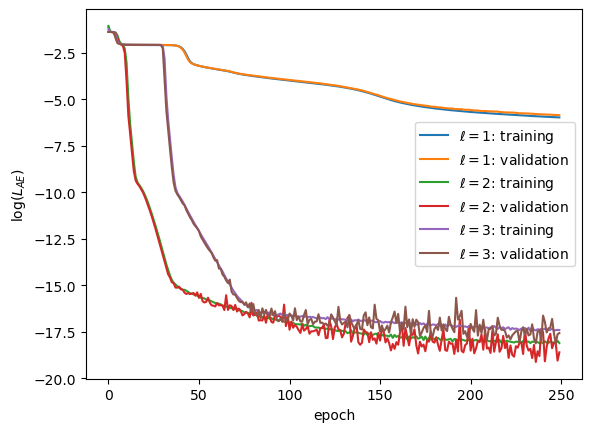

In [69]:
plt.plot(np.log(history_AE_filt_1.history['loss']), label='$\ell=1$: training')
plt.plot(np.log(history_AE_filt_1.history['val_loss']), label='$\ell=1$: validation')
plt.plot(np.log(history_AE_filt_2.history['loss']), label='$\ell=2$: training')
plt.plot(np.log(history_AE_filt_2.history['val_loss']), label='$\ell=2$: validation')
plt.plot(np.log(history_AE_filt_3.history['loss']), label='$\ell=3$: training')
plt.plot(np.log(history_AE_filt_3.history['val_loss']), label='$\ell=3$: validation')
plt.xlabel('epoch')
plt.ylabel('$\log(L_{AE})$')
plt.legend()
plt.savefig('../LaTeX/Notes/Figures/lossAE_filtered_higgs.png')

#### l=1 prediction

In [72]:
encoded_points = encoder_filt_1.predict(x_filtered)

2441/2441 [==============================] - 1s 222us/step


(array([ 2769.,  1982.,  7140., 18210., 17382., 18682.,  7776.,  1679.,
          783.,  1704.]),
 array([-7.39485073, -5.7463026 , -4.09775448, -2.44920659, -0.80065858,
         0.84788942,  2.49643755,  4.14498568,  5.79353333,  7.44208145,
         9.09062958]),
 <BarContainer object of 10 artists>)

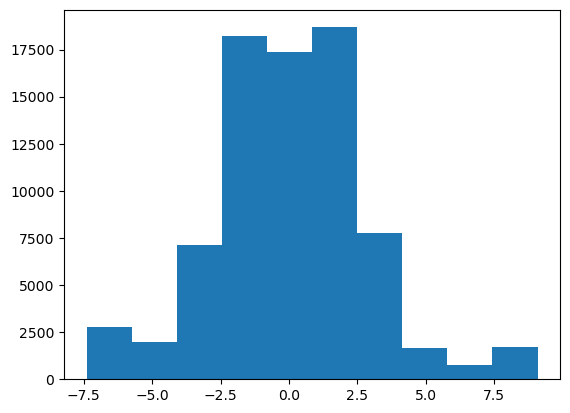

In [73]:
plt.hist(encoded_points)

In [74]:
t = np.linspace(-7,7,100)
predicted_x_1 = decoder_filt_1.predict(t)

4/4 [==============================] - 0s 668us/step


In [75]:
predicted_x_1.shape

(100, 4)

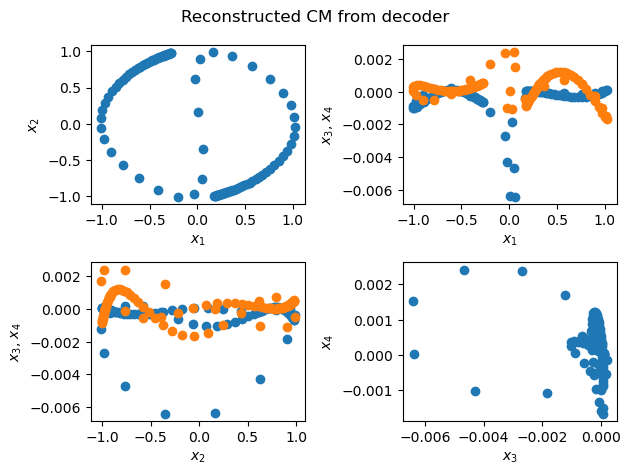

In [76]:
fig, ax =plt.subplots(2,2)
fig.suptitle('Reconstructed CM from decoder')
ax[0,0].scatter(predicted_x_1[:,0],predicted_x_1[:,1])
ax[0,0].set_xlabel('$x_1$')
ax[0,0].set_ylabel('$x_2$')

ax[0,1].scatter(predicted_x_1[:,0],predicted_x_1[:,2])
ax[0,1].scatter(predicted_x_1[:,0],predicted_x_1[:,3])
ax[0,1].set_xlabel('$x_1$')
ax[0,1].set_ylabel('$x_3$, $x_4$')

ax[1,0].scatter(predicted_x_1[:,1],predicted_x_1[:,2])
ax[1,0].scatter(predicted_x_1[:,1],predicted_x_1[:,3])
ax[1,0].set_xlabel('$x_2$')
ax[1,0].set_ylabel('$x_3$, $x_4$')

ax[1,1].scatter(predicted_x_1[:,2],predicted_x_1[:,3])
ax[1,1].set_xlabel('$x_3$')
ax[1,1].set_ylabel('$x_4$')
plt.tight_layout()

The bad prediction seems to be due to the fact that the circle has the endpoints identified.

### Filtering to break circle

In [152]:
encoded_points = encoder_2.predict(x)

3125/3125 [==============================] - 1s 217us/step


In [153]:
encoded_points[:10]

array([[-0.47625953,  1.706772  ],
       [ 0.09931856,  0.3429327 ],
       [-1.2234576 , -0.5638795 ],
       [ 0.29123428, -1.0014274 ],
       [ 1.5985248 ,  0.6529094 ],
       [ 0.09931856,  0.3429327 ],
       [ 0.09931856,  0.34293264],
       [ 0.09931856,  0.3429327 ],
       [ 0.80964947,  1.9397985 ],
       [-0.98347235, -0.84679663]], dtype=float32)

In [164]:
centr_appr = [ 0.09931856,  0.3429327]
tan_angle = 3

#func = lambda x: (np.sqrt((x[0]-centr_appr[0])**2+(x[1]-centr_appr[1])**2)>.5) and (x[0]<threshold)
func = lambda x: (np.sqrt((x[0]-centr_appr[0])**2+(x[1]-centr_appr[1])**2)>.5) and ~(((x[1]-centr_appr[1])/(x[0]-centr_appr[0])>tan_angle) and (x[0]-centr_appr[0])>0)
mask = [func(i) for i in encoded_points]

If a smaller angle is chose, the artificial encoded points remain.

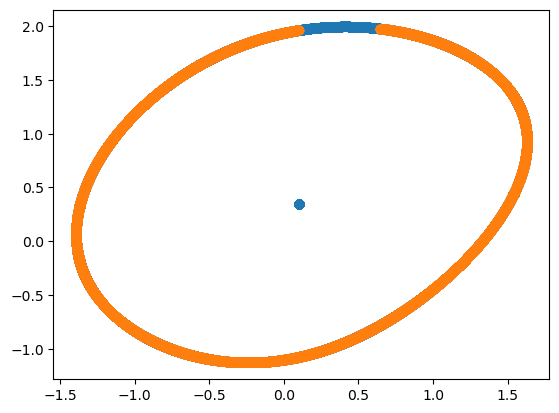

In [166]:
plt.scatter(encoded_points[:,0],encoded_points[:,1])
plt.scatter(encoded_points[mask,0],encoded_points[mask,1])

In [167]:
x_filtered = x[mask]
x_filt_train, x_filt_test = train_test_split(x_filtered, test_size=0.15, random_state=42)
print(f'shape of total set of points: {x_filtered.shape}')
print(f'shape of training set of points: {x_filt_train.shape}')
print(f'shape of validation set of points: {x_filt_test.shape}')

shape of total set of points: (75953, 4)
shape of training set of points: (64560, 4)
shape of validation set of points: (11393, 4)


In [168]:
input_dim = 4  
latent_dim = 1

# Encoder
inputs = layers.Input(shape=(input_dim,))
encoded = layers.Dense(32, activation='sigmoid')(inputs)
encoded = layers.Dense(16, activation='sigmoid')(encoded)
encoded = layers.Dense(8, activation='sigmoid')(encoded)
encoded = layers.Dense(latent_dim)(encoded)  

# Decoder
decoded = layers.Dense(8, activation='sigmoid')(encoded)
decoded = layers.Dense(16, activation='sigmoid')(decoded)
decoded = layers.Dense(32, activation='sigmoid')(decoded)
decoded = layers.Dense(input_dim)(decoded)  

# Autoencoder 
autoencoder = models.Model(inputs, decoded)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
autoencoder.compile(optimizer=optimizer, loss='mse')

In [169]:
epochs = 250
history_AE_broken_1 = autoencoder.fit(x_filt_train, x_filt_train, epochs=epochs, batch_size=100, shuffle=True,validation_data=(x_filt_test, x_filt_test))

Epoch 1/250
646/646 [==============================] - 1s 700us/step - loss: 0.4980 - val_loss: 0.2652
Epoch 2/250
646/646 [==============================] - 0s 657us/step - loss: 0.2523 - val_loss: 0.2499
Epoch 3/250
646/646 [==============================] - 0s 601us/step - loss: 0.2498 - val_loss: 0.2498
Epoch 4/250
646/646 [==============================] - 0s 607us/step - loss: 0.2498 - val_loss: 0.2498
Epoch 5/250
646/646 [==============================] - 0s 588us/step - loss: 0.2497 - val_loss: 0.2496
Epoch 6/250
646/646 [==============================] - 0s 588us/step - loss: 0.2489 - val_loss: 0.2470
Epoch 7/250
646/646 [==============================] - 0s 606us/step - loss: 0.2373 - val_loss: 0.2208
Epoch 8/250
646/646 [==============================] - 0s 697us/step - loss: 0.1908 - val_loss: 0.1596
Epoch 9/250
646/646 [==============================] - 0s 624us/step - loss: 0.1419 - val_loss: 0.1333
Epoch 10/250
646/646 [==============================] - 0s 645us/step - l

In [170]:
autoencoder_broken_1 = autoencoder
encoder_broken_1 = models.Model(inputs,encoded)
decoder_broken_1 = models.Model(encoded,decoded)

In [142]:
input_dim = 4  
latent_dim = 2

# Encoder
inputs = layers.Input(shape=(input_dim,))
encoded = layers.Dense(32, activation='sigmoid')(inputs)
encoded = layers.Dense(16, activation='sigmoid')(encoded)
encoded = layers.Dense(8, activation='sigmoid')(encoded)
encoded = layers.Dense(latent_dim)(encoded)  

# Decoder
decoded = layers.Dense(8, activation='sigmoid')(encoded)
decoded = layers.Dense(16, activation='sigmoid')(decoded)
decoded = layers.Dense(32, activation='sigmoid')(decoded)
decoded = layers.Dense(input_dim)(decoded)  

# Autoencoder 
autoencoder = models.Model(inputs, decoded)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
autoencoder.compile(optimizer=optimizer, loss='mse')

In [143]:
epochs = 250
history_AE_broken_2 = autoencoder.fit(x_filt_train, x_filt_train, epochs=epochs, batch_size=100, shuffle=True,validation_data=(x_filt_test, x_filt_test))

Epoch 1/250
652/652 [==============================] - 1s 659us/step - loss: 0.2527 - val_loss: 0.2499
Epoch 2/250
652/652 [==============================] - 0s 568us/step - loss: 0.2498 - val_loss: 0.2495
Epoch 3/250
652/652 [==============================] - 0s 571us/step - loss: 0.2479 - val_loss: 0.2435
Epoch 4/250
652/652 [==============================] - 0s 565us/step - loss: 0.2187 - val_loss: 0.1805
Epoch 5/250
652/652 [==============================] - 0s 571us/step - loss: 0.1489 - val_loss: 0.1335
Epoch 6/250
652/652 [==============================] - 0s 570us/step - loss: 0.1304 - val_loss: 0.1293
Epoch 7/250
652/652 [==============================] - 0s 574us/step - loss: 0.1276 - val_loss: 0.1274
Epoch 8/250
652/652 [==============================] - 0s 569us/step - loss: 0.1259 - val_loss: 0.1256
Epoch 9/250
652/652 [==============================] - 0s 572us/step - loss: 0.1247 - val_loss: 0.1247
Epoch 10/250
652/652 [==============================] - 0s 573us/step - l

In [144]:
autoencoder_broken_2 = autoencoder
encoder_broken_2 = models.Model(inputs,encoded)
decoder_broken_2 = models.Model(encoded,decoded)

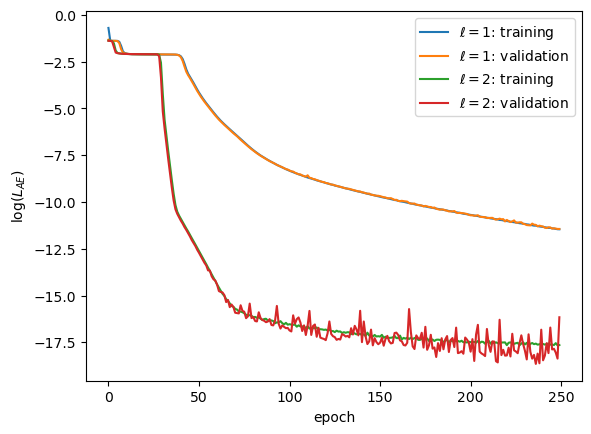

In [171]:
plt.plot(np.log(history_AE_broken_1.history['loss']), label='$\ell=1$: training')
plt.plot(np.log(history_AE_broken_1.history['val_loss']), label='$\ell=1$: validation')
plt.plot(np.log(history_AE_broken_2.history['loss']), label='$\ell=2$: training')
plt.plot(np.log(history_AE_broken_2.history['val_loss']), label='$\ell=2$: validation')
plt.xlabel('epoch')
plt.ylabel('$\log(L_{AE})$')
plt.legend()
plt.savefig('../LaTeX/Notes/Figures/lossAE_filtered_higgs.png')

#### l=1 prediction

In [172]:
encoded_points = encoder_broken_1.predict(x_filtered)

2374/2374 [==============================] - 1s 208us/step


min value of t: [-1.2041242]
max value of t: [0.9823351]


(array([ 1961.,  3262.,  7382.,  7046., 15896., 14948.,  9230.,  8979.,
         4872.,  2377.]),
 array([-1.20412421, -0.98547828, -0.76683235, -0.54818642, -0.32954049,
        -0.11089456,  0.10775137,  0.3263973 ,  0.54504323,  0.76368916,
         0.98233509]),
 <BarContainer object of 10 artists>)

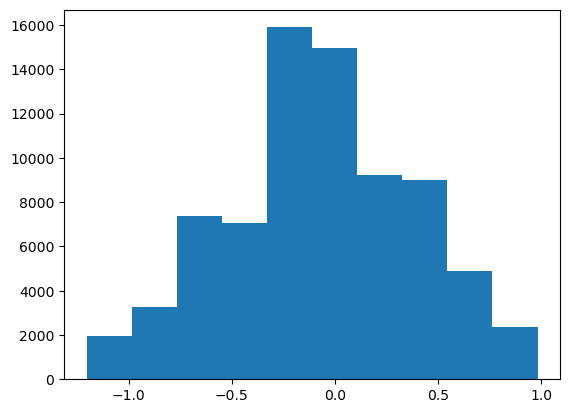

In [173]:
print(f'min value of t: {min(encoded_points)}')
print(f'max value of t: {max(encoded_points)}')
plt.hist(encoded_points)

In [174]:
t = np.linspace(-1.2,0.98,100)
t_ext = np.linspace(-1.5,1.2,100)

predicted_x_1 = decoder_broken_1.predict(t)
predicted_x_1_ext = decoder_broken_1.predict(t_ext)

4/4 [==============================] - 0s 532us/step


In [175]:
predicted_x_1.shape

(100, 4)

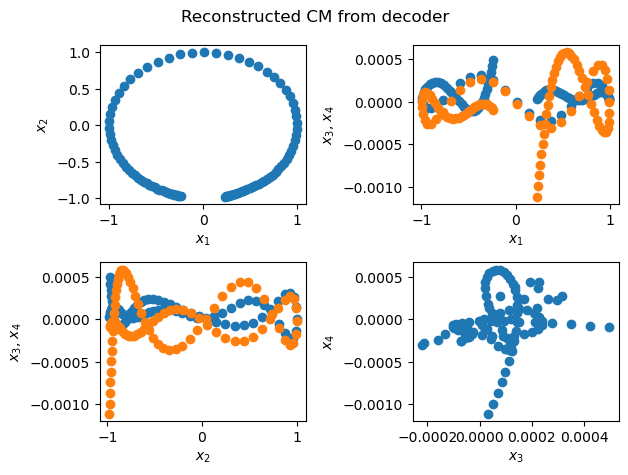

In [176]:
fig, ax =plt.subplots(2,2)
fig.suptitle('Reconstructed CM from decoder')
ax[0,0].scatter(predicted_x_1[:,0],predicted_x_1[:,1])
ax[0,0].set_xlabel('$x_1$')
ax[0,0].set_ylabel('$x_2$')

ax[0,1].scatter(predicted_x_1[:,0],predicted_x_1[:,2])
ax[0,1].scatter(predicted_x_1[:,0],predicted_x_1[:,3])
ax[0,1].set_xlabel('$x_1$')
ax[0,1].set_ylabel('$x_3$, $x_4$')

ax[1,0].scatter(predicted_x_1[:,1],predicted_x_1[:,2])
ax[1,0].scatter(predicted_x_1[:,1],predicted_x_1[:,3])
ax[1,0].set_xlabel('$x_2$')
ax[1,0].set_ylabel('$x_3$, $x_4$')

ax[1,1].scatter(predicted_x_1[:,2],predicted_x_1[:,3])
ax[1,1].set_xlabel('$x_3$')
ax[1,1].set_ylabel('$x_4$')
plt.tight_layout()

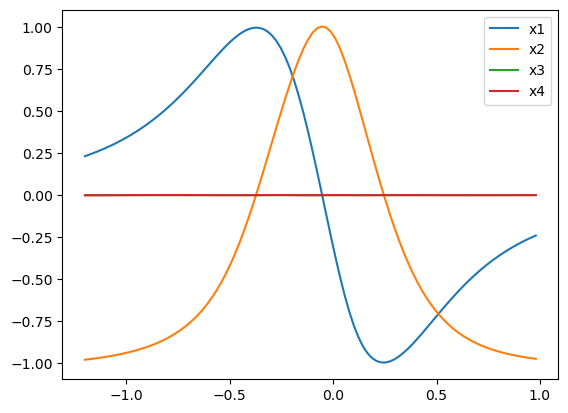

In [177]:
for i in range(4):
    plt.plot(t,predicted_x_1[:,i],label='x'+str(i+1))
plt.legend()

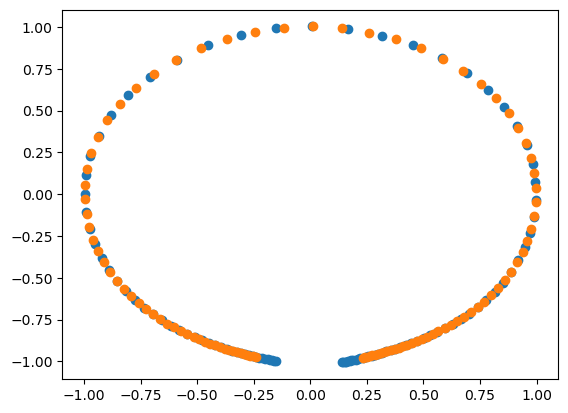

In [178]:
plt.scatter(predicted_x_1_ext[:,0],predicted_x_1_ext[:,1])
plt.scatter(predicted_x_1[:,0],predicted_x_1[:,1])

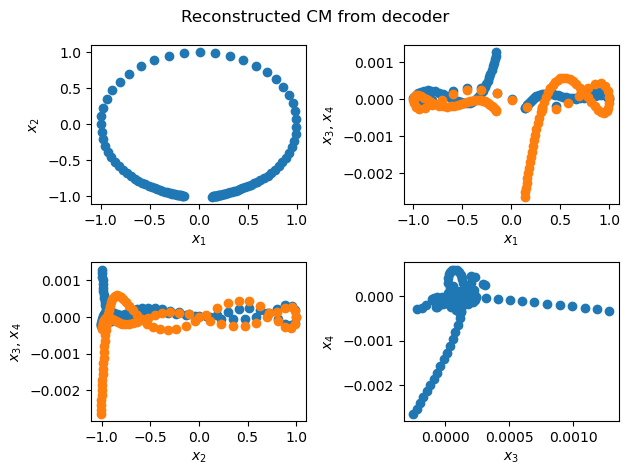

In [179]:
fig, ax =plt.subplots(2,2)
fig.suptitle('Reconstructed CM from decoder')
ax[0,0].scatter(predicted_x_1_ext[:,0],predicted_x_1_ext[:,1])
ax[0,0].set_xlabel('$x_1$')
ax[0,0].set_ylabel('$x_2$')

ax[0,1].scatter(predicted_x_1_ext[:,0],predicted_x_1_ext[:,2])
ax[0,1].scatter(predicted_x_1_ext[:,0],predicted_x_1_ext[:,3])
ax[0,1].set_xlabel('$x_1$')
ax[0,1].set_ylabel('$x_3$, $x_4$')

ax[1,0].scatter(predicted_x_1_ext[:,1],predicted_x_1_ext[:,2])
ax[1,0].scatter(predicted_x_1_ext[:,1],predicted_x_1_ext[:,3])
ax[1,0].set_xlabel('$x_2$')
ax[1,0].set_ylabel('$x_3$, $x_4$')

ax[1,1].scatter(predicted_x_1_ext[:,2],predicted_x_1_ext[:,3])
ax[1,1].set_xlabel('$x_3$')
ax[1,1].set_ylabel('$x_4$')
plt.tight_layout()

The values for x1 and x2 extrapolate very well! For x3 and x4, not so much...

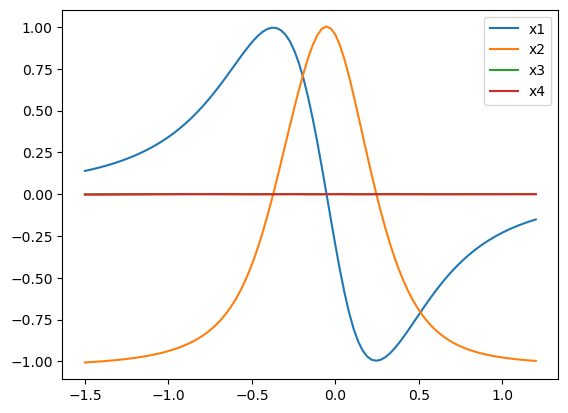

In [180]:
for i in range(4):
    plt.plot(t_ext,predicted_x_1_ext[:,i],label='x'+str(i+1))
plt.legend()

Note that from t = -0.4 to t = 0.2 the function x1(t) is bijective. Therefore, we can write x2(t) as x2(x1) in this interval. 
To do this, Taylor-expand x1(t) around t_* where x1(t_*) = 0 [t_* = -0.8 in the case above], and invert this polynomial to get t(x1)

This can then be fed into the autoencoder to get x2(x1)

IMPLEMENT!!!

In [215]:
# Saving the model
encoder_broken_1.save('Output/encoder_potHiggs4_ell1_broken_circle.h5')
decoder_broken_1.save('Output/decoder_potHiggs4_ell1_broken_circle.h5')

In [207]:
encoder_weights = [w.numpy().tolist() for w in encoder_broken_1.weights]

In [208]:
print(len(encoder_weights))
for w in encoder_weights: print(w)

8
[[-1.5461961030960083, -0.38192859292030334, -0.18361333012580872, -0.4009762406349182, -1.0722665786743164, -0.44784289598464966, -2.395479679107666, 0.1998985856771469, -0.29252639412879944, -0.6552305817604065, -1.3434230089187622, 0.3230832815170288, -1.3561652898788452, 1.1825802326202393, -0.6014266014099121, 2.489337205886841, -0.10714200884103775, -2.5204551219940186, -0.5366157293319702, -0.961833655834198, 0.605002224445343, -0.7448726296424866, -1.3680131435394287, -2.411466360092163, -1.7110872268676758, 1.6129932403564453, 2.1618196964263916, 0.11364462971687317, -0.18729686737060547, -0.7179065942764282, 0.7517390251159668, 0.22817601263523102], [-1.7057647705078125, 1.3494582176208496, 1.5203415155410767, 1.347943902015686, 1.3528631925582886, 0.7473905682563782, 0.4337921142578125, 2.053661823272705, 1.417022466659546, 1.0577120780944824, -1.0150456428527832, 1.726232647895813, -1.0620977878570557, 1.0399055480957031, 2.4362988471984863, -0.477040559053421, -1.0343881

In [201]:
encoder_broken_1.summary()

Model: "model_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_27 (InputLayer)       [(None, 4)]               0         
                                                                 
 dense_104 (Dense)           (None, 32)                160       
                                                                 
 dense_105 (Dense)           (None, 16)                528       
                                                                 
 dense_106 (Dense)           (None, 8)                 136       
                                                                 
 dense_107 (Dense)           (None, 1)                 9         
                                                                 
Total params: 833
Trainable params: 833
Non-trainable params: 0
_________________________________________________________________


In [202]:

decoder_broken_1.summary()

Model: "model_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_28 (InputLayer)       [(None, 1)]               0         
                                                                 
 dense_108 (Dense)           (None, 8)                 16        
                                                                 
 dense_109 (Dense)           (None, 16)                144       
                                                                 
 dense_110 (Dense)           (None, 32)                544       
                                                                 
 dense_111 (Dense)           (None, 4)                 132       
                                                                 
Total params: 836
Trainable params: 836
Non-trainable params: 0
_________________________________________________________________
